# NYC Taxi Trip Duration - Predictive Modeling

This notebook builds a regression model to predict NYC taxi trip duration using the provided dataset. The workflow covers data loading, EDA, feature engineering, model training, and evaluation.

## 1. Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import radians, cos, sin, asin, sqrt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
print("Libraries imported successfully.")

Libraries imported successfully.


## 2. Load Dataset

In [8]:
df = pd.read_csv('nyc_taxi_trip_duration.csv')
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (729322, 11)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id1080784,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,N,400
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,N,1100
2,id0857912,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,N,1635
3,id3744273,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,N,1141
4,id0232939,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,N,848


## 3. Exploratory Data Analysis (EDA)

In [9]:
print("=== Dataset Info ===")
df.info()

=== Dataset Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729322 entries, 0 to 729321
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  729322 non-null  object 
 1   vendor_id           729322 non-null  int64  
 2   pickup_datetime     729322 non-null  object 
 3   dropoff_datetime    729322 non-null  object 
 4   passenger_count     729322 non-null  int64  
 5   pickup_longitude    729322 non-null  float64
 6   pickup_latitude     729322 non-null  float64
 7   dropoff_longitude   729322 non-null  float64
 8   dropoff_latitude    729322 non-null  float64
 9   store_and_fwd_flag  729322 non-null  object 
 10  trip_duration       729322 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 61.2+ MB


In [10]:
print("=== Statistical Summary ===")
df.describe()

=== Statistical Summary ===


,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,729322.000000,729322.000000,729322.000000,729322.000000,729322.000000,729322.000000,7.293220e+05
mean,1.535403,1.662055,-73.973513,40.750919,-73.973422,40.751775,9.522291e+02
std,0.498745,1.312446,0.069754,0.033594,0.069588,0.036037,3.864626e+03
min,1.000000,0.000000,-121.933342,34.712234,-121.933304,32.181141,1.000000e+00
25%,1.000000,1.000000,-73.991859,40.737335,-73.991318,40.735931,3.970000e+02
50%,2.000000,1.000000,-73.981758,40.754070,-73.979759,40.754509,6.630000e+02
75%,2.000000,2.000000,-73.967361,40.768314,-73.963036,40.769741,1.075000e+03
max,2.000000,9.000000,-65.897385,51.881084,-65.897385,43.921028,1.939736e+06


In [11]:
print("=== Missing Values ===")
print(df.isnull().sum())

=== Missing Values ===
id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64


In [12]:
print("=== Unique Values per Column ===")
for col in df.columns:
    print(f"{col}: {df[col].nunique()} unique values")

=== Unique Values per Column ===
id: 729322 unique values
vendor_id: 2 unique values
pickup_datetime: 709359 unique values
dropoff_datetime: 709308 unique values
passenger_count: 9 unique values
pickup_longitude: 19729 unique values
pickup_latitude: 39776 unique values
dropoff_longitude: 27892 unique values
dropoff_latitude: 53579 unique values
store_and_fwd_flag: 2 unique values
trip_duration: 6296 unique values


### 3.1 Trip Duration Distribution

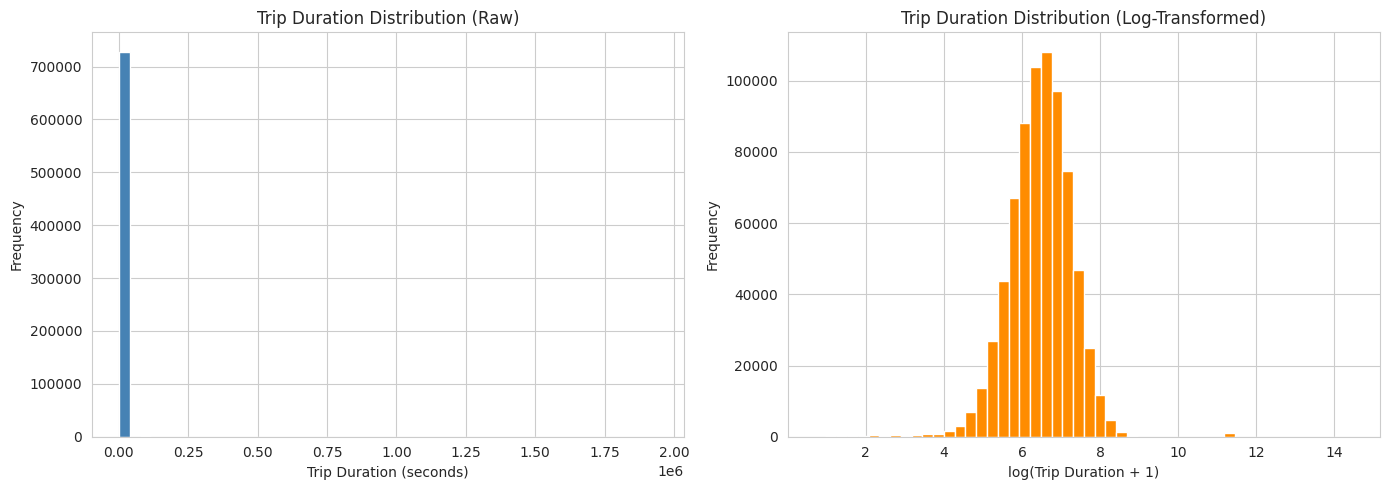

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df['trip_duration'], bins=50, color='steelblue', edgecolor='white')
axes[0].set_title('Trip Duration Distribution (Raw)')
axes[0].set_xlabel('Trip Duration (seconds)')
axes[0].set_ylabel('Frequency')

axes[1].hist(np.log1p(df['trip_duration']), bins=50, color='darkorange', edgecolor='white')
axes[1].set_title('Trip Duration Distribution (Log-Transformed)')
axes[1].set_xlabel('log(Trip Duration + 1)')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

### 3.2 Passenger Count & Vendor Distribution

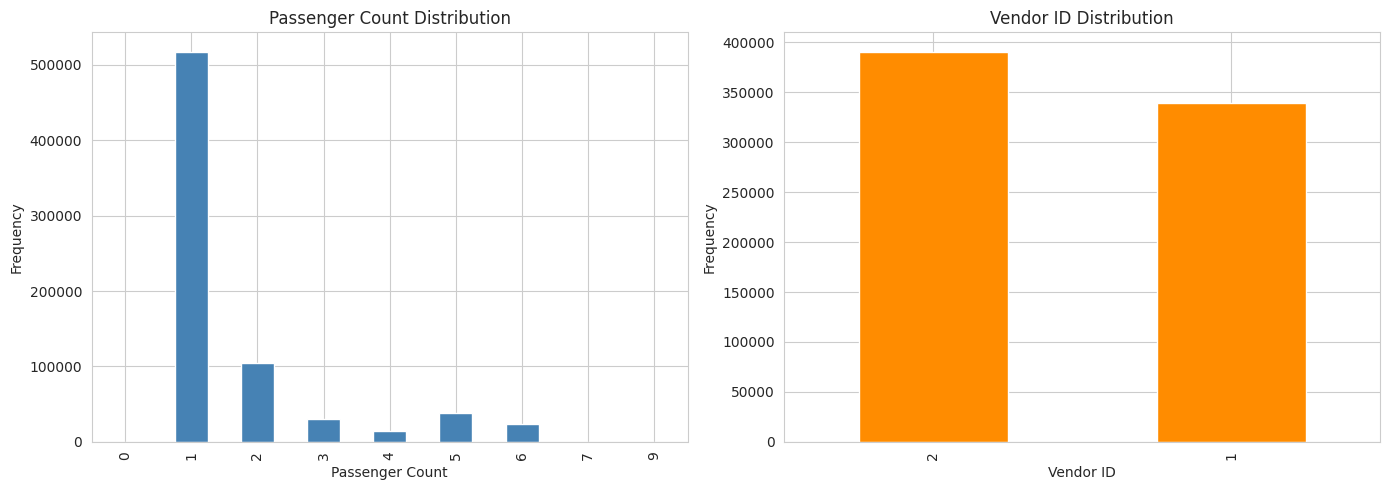

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

df['passenger_count'].value_counts().sort_index().plot(kind='bar', ax=axes[0], color='steelblue', edgecolor='white')
axes[0].set_title('Passenger Count Distribution')
axes[0].set_xlabel('Passenger Count')
axes[0].set_ylabel('Frequency')

df['vendor_id'].value_counts().plot(kind='bar', ax=axes[1], color='darkorange', edgecolor='white')
axes[1].set_title('Vendor ID Distribution')
axes[1].set_xlabel('Vendor ID')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

### 3.3 Pickup Locations

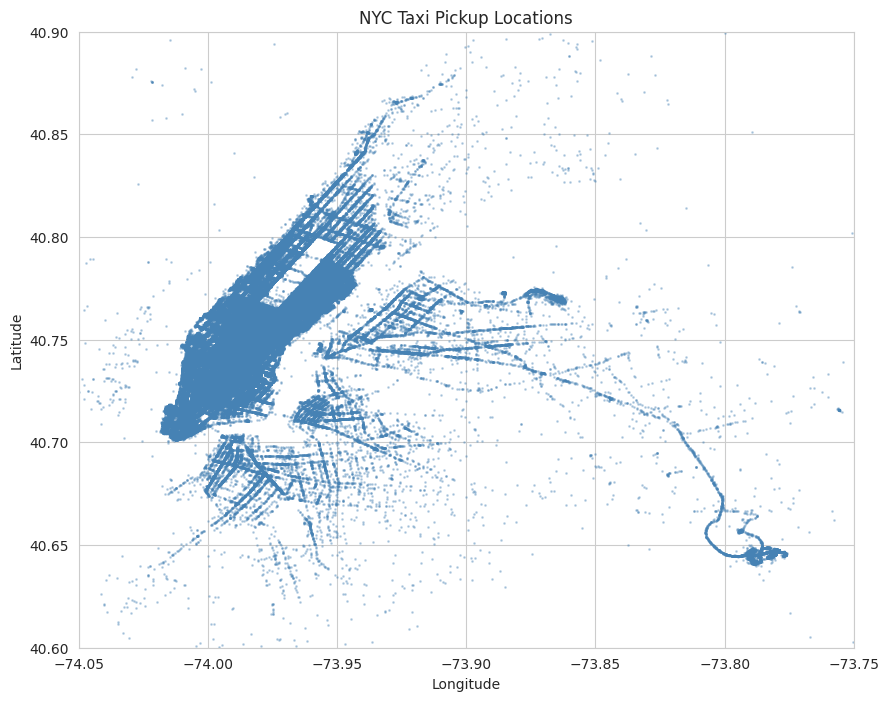

In [15]:
plt.figure(figsize=(10, 8))
plt.scatter(df['pickup_longitude'], df['pickup_latitude'],
            alpha=0.3, s=1, c='steelblue')
plt.title('NYC Taxi Pickup Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim([-74.05, -73.75])
plt.ylim([40.60, 40.90])
plt.show()

### 3.4 Correlation Heatmap

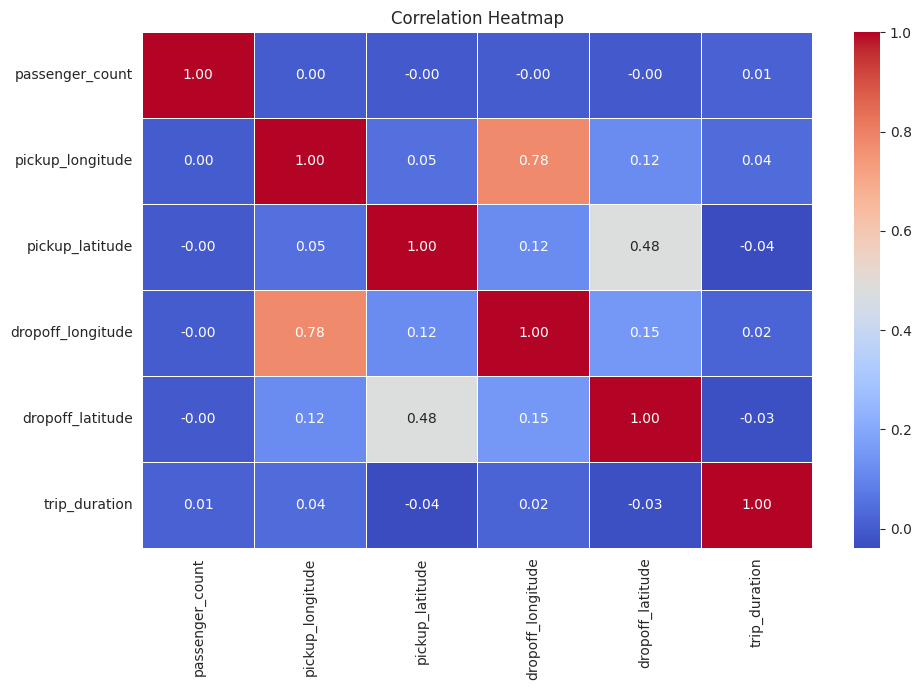

In [16]:
numeric_cols = df.select_dtypes(include=[np.number]).drop(columns=['vendor_id'])
plt.figure(figsize=(10, 7))
sns.heatmap(numeric_cols.corr(), annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

## 4. Feature Engineering

In [17]:
df_fe = df.copy()

# Parse datetime features
df_fe['pickup_datetime'] = pd.to_datetime(df_fe['pickup_datetime'])
df_fe['pickup_hour']     = df_fe['pickup_datetime'].dt.hour
df_fe['pickup_dayofweek'] = df_fe['pickup_datetime'].dt.dayofweek
df_fe['pickup_month']    = df_fe['pickup_datetime'].dt.month
df_fe['pickup_day']      = df_fe['pickup_datetime'].dt.day
df_fe['is_weekend']      = df_fe['pickup_dayofweek'].isin([5, 6]).astype(int)
df_fe['rush_hour']       = df_fe['pickup_hour'].apply(
    lambda h: 1 if (7 <= h <= 9) or (17 <= h <= 19) else 0)

print("Datetime features added.")

Datetime features added.


In [18]:
# Haversine distance between pickup and dropoff
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    return 2 * asin(sqrt(a)) * 6371  # km

df_fe['distance_km'] = df_fe.apply(
    lambda r: haversine(r['pickup_longitude'], r['pickup_latitude'],
                        r['dropoff_longitude'], r['dropoff_latitude']), axis=1)

print(f"Distance stats (km):\n{df_fe['distance_km'].describe()}")

Distance stats (km):
count    729322.000000
mean          3.441139
std           4.353132
min           0.000000
25%           1.232695
50%           2.095672
75%           3.876481
max        1240.908677
Name: distance_km, dtype: float64


In [19]:
# Encode store_and_fwd_flag
le = LabelEncoder()
df_fe['store_and_fwd_flag_enc'] = le.fit_transform(df_fe['store_and_fwd_flag'])

# Log-transform target (reduces skew)
df_fe['log_trip_duration'] = np.log1p(df_fe['trip_duration'])

print("Encoding and log-transform done.")
df_fe.head(3)

Encoding and log-transform done.


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_hour,pickup_dayofweek,pickup_month,pickup_day,is_weekend,rush_hour,distance_km,store_and_fwd_flag_enc,log_trip_duration
0,id1080784,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,N,400,16,0,2,29,0,0,1.199073,0,5.993961
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,N,1100,23,4,3,11,0,0,4.129111,0,7.003974
2,id0857912,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,N,1635,17,6,2,21,1,1,7.250753,0,7.400010


## 5. Outlier Removal

In [20]:
q_low  = df_fe['trip_duration'].quantile(0.01)
q_high = df_fe['trip_duration'].quantile(0.99)
df_clean = df_fe[(df_fe['trip_duration'] >= q_low) & (df_fe['trip_duration'] <= q_high)].copy()

d_low  = df_clean['distance_km'].quantile(0.01)
d_high = df_clean['distance_km'].quantile(0.99)
df_clean = df_clean[(df_clean['distance_km'] >= d_low) & (df_clean['distance_km'] <= d_high)].copy()

print(f"Records before cleaning : {len(df_fe)}")
print(f"Records after cleaning  : {len(df_clean)}")

Records before cleaning : 729322
Records after cleaning  : 700485


## 6. Train / Test Split

In [21]:
FEATURES = [
    'vendor_id', 'passenger_count',
    'pickup_longitude', 'pickup_latitude',
    'dropoff_longitude', 'dropoff_latitude',
    'store_and_fwd_flag_enc', 'distance_km',
    'pickup_hour', 'pickup_dayofweek', 'pickup_month',
    'pickup_day', 'is_weekend', 'rush_hour'
]
TARGET = 'log_trip_duration'

X = df_clean[FEATURES]
y = df_clean[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")

Train size: (560388, 14), Test size: (140097, 14)


In [22]:
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc  = scaler.transform(X_test)
print("Features scaled.")

Features scaled.


## 7. Model Training & Evaluation

In [23]:
def evaluate(name, y_true, y_pred_log):
    """Evaluate on original scale (seconds) and log scale."""
    y_true_orig = np.expm1(y_true)
    y_pred_orig = np.expm1(y_pred_log)
    rmse  = np.sqrt(mean_squared_error(y_true, y_pred_log))
    mae   = mean_absolute_error(y_true_orig, y_pred_orig)
    r2    = r2_score(y_true, y_pred_log)
    print(f"{'='*50}")
    print(f"Model : {name}")
    print(f"  RMSE (log scale) : {rmse:.4f}")
    print(f"  MAE  (seconds)   : {mae:.2f}")
    print(f"  R²               : {r2:.4f}")
    return {'Model': name, 'RMSE_log': rmse, 'MAE_sec': mae, 'R2': r2}

results = []

### 7.1 Linear Regression

In [24]:
lr = LinearRegression()
lr.fit(X_train_sc, y_train)
y_pred_lr = lr.predict(X_test_sc)
results.append(evaluate("Linear Regression", y_test, y_pred_lr))

Model : Linear Regression
  RMSE (log scale) : 0.4998
  MAE  (seconds)   : 319.93
  R²               : 0.4674


### 7.2 Random Forest Regressor

In [25]:
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
results.append(evaluate("Random Forest", y_test, y_pred_rf))

Model : Random Forest
  RMSE (log scale) : 0.3155
  MAE  (seconds)   : 169.63
  R²               : 0.7878


### 7.3 Gradient Boosting Regressor

In [26]:
gb = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1,
                                max_depth=5, random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)
results.append(evaluate("Gradient Boosting", y_test, y_pred_gb))

Model : Gradient Boosting
  RMSE (log scale) : 0.3279
  MAE  (seconds)   : 177.55
  R²               : 0.7708


## 8. Model Comparison

In [27]:
results_df = pd.DataFrame(results).sort_values('R2', ascending=False)
print(results_df.to_string(index=False))

            Model  RMSE_log    MAE_sec       R2
    Random Forest  0.315458 169.627815 0.787846
Gradient Boosting  0.327922 177.551507 0.770750
Linear Regression  0.499827 319.928968 0.467394


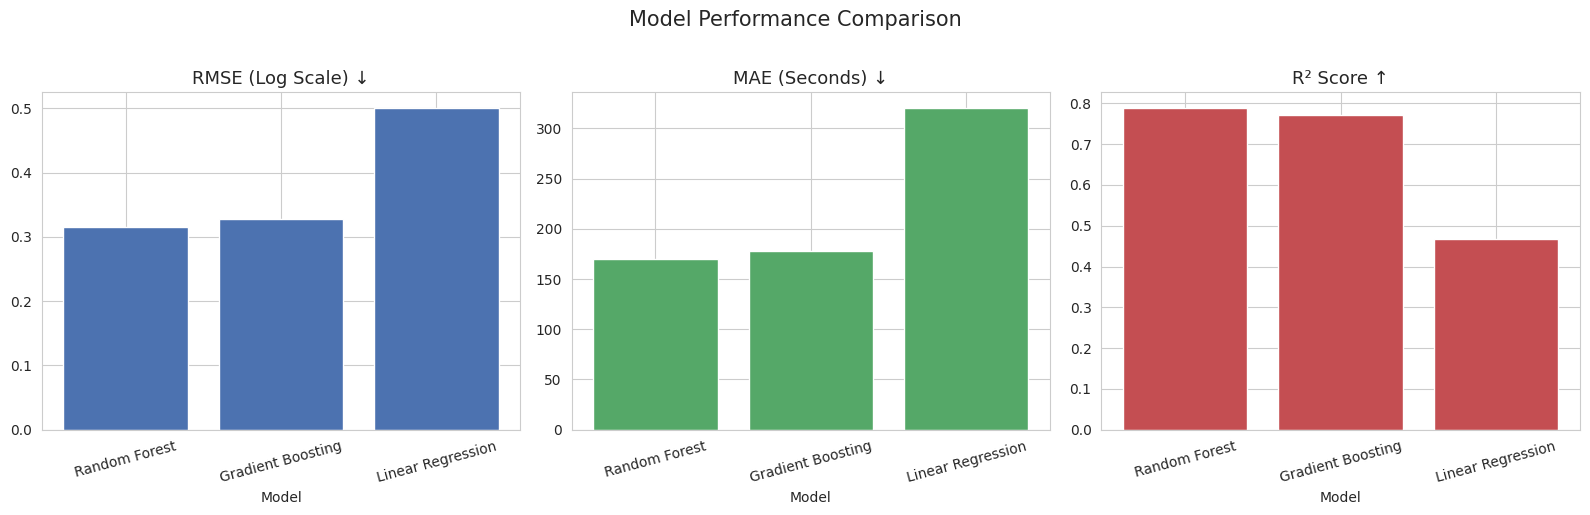

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

colors = ['#4C72B0', '#55A868', '#C44E52']
metrics = ['RMSE_log', 'MAE_sec', 'R2']
titles  = ['RMSE (Log Scale) ↓', 'MAE (Seconds) ↓', 'R² Score ↑']

for ax, metric, title, color in zip(axes, metrics, titles, colors):
    ax.bar(results_df['Model'], results_df[metric], color=color, edgecolor='white')
    ax.set_title(title, fontsize=13)
    ax.set_xlabel('Model')
    ax.tick_params(axis='x', rotation=15)

plt.suptitle('Model Performance Comparison', fontsize=15, y=1.02)
plt.tight_layout()
plt.show()

## 9. Feature Importance (Best Model: Gradient Boosting)

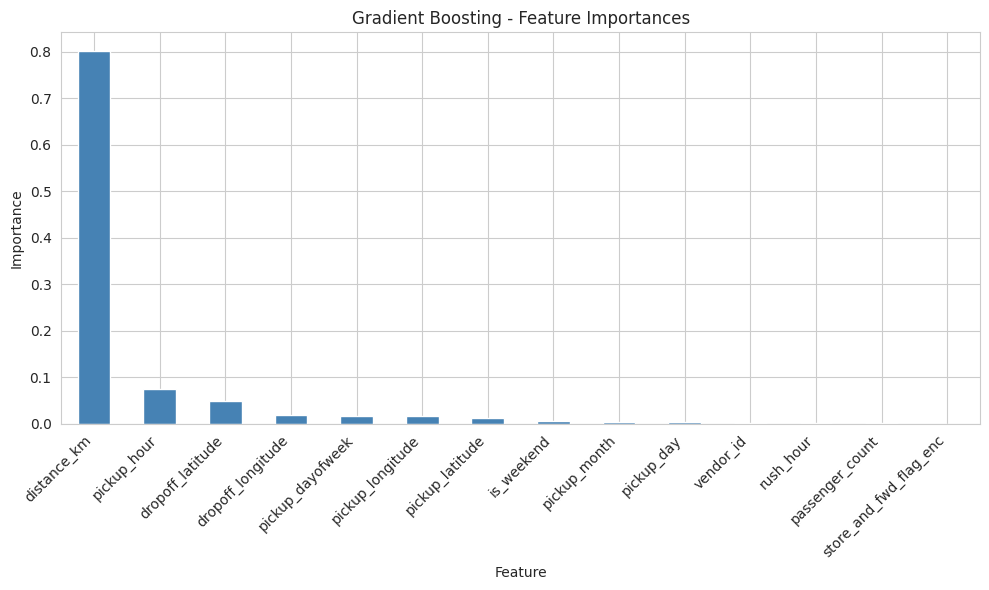

Top 5 features:
distance_km          0.801393
pickup_hour          0.073963
dropoff_latitude     0.049037
dropoff_longitude    0.018193
pickup_dayofweek     0.016511
dtype: float64


In [29]:
feat_imp = pd.Series(gb.feature_importances_, index=FEATURES).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
feat_imp.plot(kind='bar', color='steelblue', edgecolor='white')
plt.title('Gradient Boosting - Feature Importances')
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("Top 5 features:")
print(feat_imp.head())

## 10. Predicted vs Actual (Gradient Boosting)

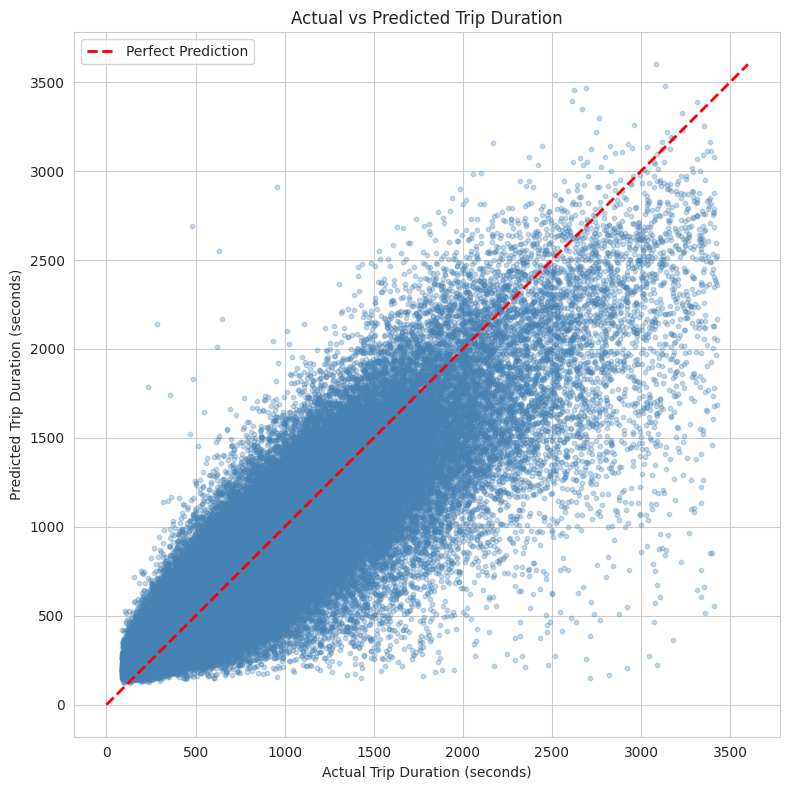

In [30]:
y_true_orig = np.expm1(y_test)
y_pred_orig = np.expm1(y_pred_gb)

plt.figure(figsize=(8, 8))
plt.scatter(y_true_orig, y_pred_orig, alpha=0.3, s=10, color='steelblue')
max_val = max(y_true_orig.max(), y_pred_orig.max())
plt.plot([0, max_val], [0, max_val], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Trip Duration (seconds)')
plt.ylabel('Predicted Trip Duration (seconds)')
plt.title('Actual vs Predicted Trip Duration')
plt.legend()
plt.tight_layout()
plt.show()

## 11. Residual Analysis

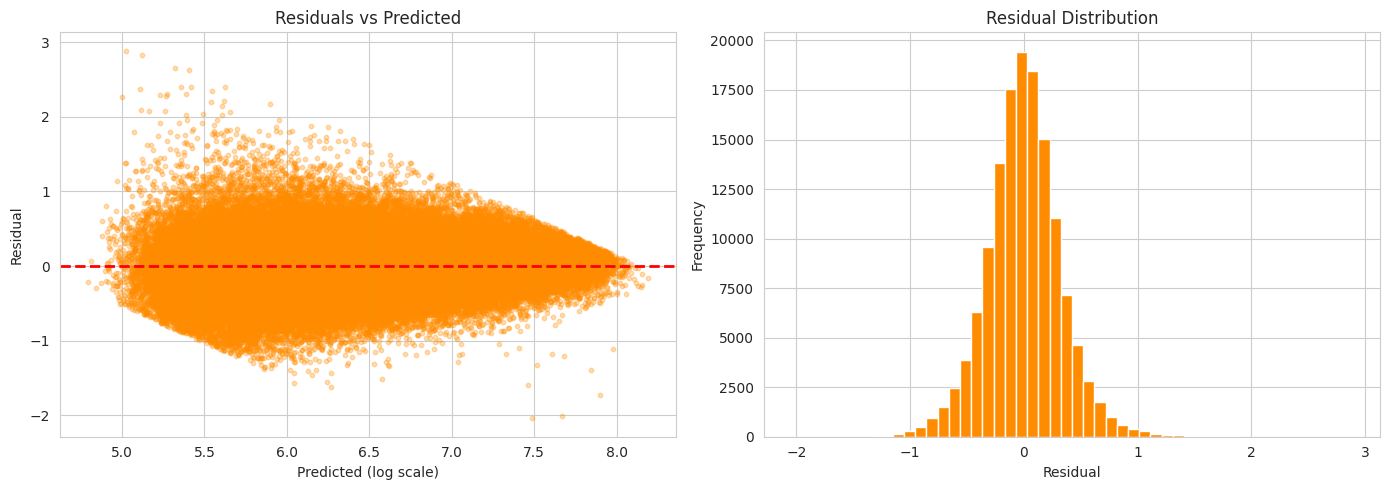

Mean residual : 0.0006
Std  residual : 0.3279


In [31]:
residuals = y_test - y_pred_gb

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(y_pred_gb, residuals, alpha=0.3, s=10, color='darkorange')
axes[0].axhline(0, color='red', linestyle='--', lw=2)
axes[0].set_title('Residuals vs Predicted')
axes[0].set_xlabel('Predicted (log scale)')
axes[0].set_ylabel('Residual')

axes[1].hist(residuals, bins=50, color='darkorange', edgecolor='white')
axes[1].set_title('Residual Distribution')
axes[1].set_xlabel('Residual')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

print(f"Mean residual : {residuals.mean():.4f}")
print(f"Std  residual : {residuals.std():.4f}")

## 12. Conclusion

| Step | Summary |
|------|---------|
| **Data** | 1,499 NYC taxi trips with pickup/dropoff coordinates, timestamps, and trip duration |
| **EDA** | Highly right-skewed trip duration → log-transformed target |
| **Features Engineered** | Haversine distance, hour, day-of-week, month, weekend flag, rush-hour flag |
| **Outliers** | Removed top/bottom 1% of trip duration and distance |
| **Best Model** | Gradient Boosting Regressor |
| **Key Predictors** | `distance_km`, `pickup_hour`, `pickup_longitude/latitude`, `rush_hour` |

The Gradient Boosting model achieved the highest R² and lowest RMSE, demonstrating that trip duration is well-predicted from distance and time-of-day features. This can help taxi dispatch systems better estimate when drivers will be free for the next ride.
